### 단어 임베딩 모델을 활용하지 않은 전라도 사투리 이진 분류 모델 (단방향 GRU) <hr>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.vocab import build_vocab_from_iterator

from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

In [6]:
Jeolla_file = './DATA/dialect/전라도.csv'

In [7]:
jeollaDF = pd.read_csv(Jeolla_file)
jeollaDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161859 entries, 0 to 161858
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   사투리     161859 non-null  object
 1   표준어     161857 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [8]:
jeollaDF.shape

(161859, 2)

In [9]:
jeollaDF.head()

,사투리,표준어
0,시방 우리 집 짓니라고 이렇게 고생들을 허시는디 나가 참이라도 잘 준비해야제,시방 우리 집 짓느라고 이렇게 고생들을 하시는데 내가 참이라도 잘 준비해야지요
1,저그가 우리 한아버지 때부터 살던 자리인디 그런 자리에다가 집을 지은게 우리한테는 ...,저기가 우리 할아버지 때부터 살던 자리인데 그런 자리에다가 집을 지으니까 우리한테는...
2,태풍이 오면은 강한 태풍이나 바람이 치고 하면은 밖에 나가지 말고 집 안 쪽에 그 ...,태풍이 오면은 강한 태풍이나 바람이 치고 하면은 밖에 나가지 말고 집 안 쪽에 그 ...
3,아따 인자 가을이라고 논들도 차차 옷을 갈아입구마잉,와 이제 가을이라고 논들도 차차 옷을 갈아입네요
4,열두 서너 살 때부터 묵어서부터 장 장을 댕기면서 장땅 물건을 멘 날리고 그래 갖 ...,열두 서너 살 때부터 먹어서부터 장 장을 다니면서 장에다 물건을 메다 나르고 그래 ...


In [10]:
jeollaDF.drop_duplicates().shape

(126003, 2)

In [11]:
# 중복데이터 제거
jeollaDF = jeollaDF.drop_duplicates()

In [12]:
dataDF = jeollaDF.melt()
dataDF.head()

,variable,value
0,사투리,시방 우리 집 짓니라고 이렇게 고생들을 허시는디 나가 참이라도 잘 준비해야제
1,사투리,저그가 우리 한아버지 때부터 살던 자리인디 그런 자리에다가 집을 지은게 우리한테는 ...
2,사투리,태풍이 오면은 강한 태풍이나 바람이 치고 하면은 밖에 나가지 말고 집 안 쪽에 그 ...
3,사투리,아따 인자 가을이라고 논들도 차차 옷을 갈아입구마잉
4,사투리,열두 서너 살 때부터 묵어서부터 장 장을 댕기면서 장땅 물건을 멘 날리고 그래 갖 ...


In [13]:
dataDF.tail()

,variable,value
252001,표준어,배추가 짜지는 않겠는데 조금 그런 거 같으면 배추를 물에다 씻어버려
252002,표준어,이 키워본 적이 없어잉 뭣이 나을지는 모르겠어 근데 닭은 그냥 키웠어 옛날에 우리 ...
252003,표준어,사십 분 올 때 삼십 분 올 때는 좀 빠르게 하고 그러니까 한 시간 반 걸어 그렇게...
252004,표준어,이게 왜 고장이 났을까 경운기가 어디가 고장나 버렸어
252005,표준어,먹어보고 고기서 내려다 보면 뭣을 그러든지 나는 언제 이 그러니까 그때는 칼로 다 ...


In [14]:
dataDF.shape

(252006, 2)

In [15]:
dataDF.isnull().sum()

variable    0
value       2
dtype: int64

In [16]:
# 결측값 있는 행 제거
dataDF.dropna(inplace = True)

In [17]:
# 컬럼명 변경
dataDF.columns = ['label', 'text']

In [18]:
def remove_stopwords(text, stop_words_list):
    tokens = text.split(' ')
    meaningful_words = [w for w in tokens if not w in stop_words_list]
    return ' '.join(meaningful_words)

def sentence_refine(feature, file_name = './DATA/dialect/전라도.csv', stop_word_file = './DATA/hangul_stopword.txt'):
    f = open(stop_word_file, 'r', encoding = 'utf-8')
    stop_words_list = f.read().split('\n')
    f.close()
    df = pd.read_csv(file_name)
    df = df.drop_duplicates()
    df.dropna(inplace = True)
    
    # 라벨 지정
    df = df.melt()

    # 컬럼명 변경
    df.columns = ['label', 'text']

    df[feature] = df[feature].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', regex = True)
    df[feature] = df[feature].str.replace('^ +', '', regex = True)
    df[feature] = df[feature].str.replace('[^\w\s]', '', regex = True)
    df[feature] = df[feature].str.replace('([ㄱ-ㅎㅏ-ㅣ]+)', '', regex = True)
    df[feature] = df[feature].replace(r'[{}]'.format(string.punctuation), '', regex=True)
    # df[feature] = df[feature].str.replace('[a-zA-Z]', '', regex = True)
    
    df[feature] = df[feature].apply(lambda x : remove_stopwords(x, stop_words_list))
    df = df[df[feature] != '']
    # df[feature] = documentDF[documentDF[feature].str.len() != 0].squeeze()
    df[feature] = df[feature].str.strip()
    # df = df[df[feature].str.len() >= 2]
    df.reset_index(drop = True, inplace = True)
    
    for ind in range(df.shape[0]):
        if type(df.loc[ind, 'text']) is float:
            print('float')
    
    return df

In [19]:
dataDF

,label,text
0,사투리,시방 우리 집 짓니라고 이렇게 고생들을 허시는디 나가 참이라도 잘 준비해야제
1,사투리,저그가 우리 한아버지 때부터 살던 자리인디 그런 자리에다가 집을 지은게 우리한테는 ...
2,사투리,태풍이 오면은 강한 태풍이나 바람이 치고 하면은 밖에 나가지 말고 집 안 쪽에 그 ...
3,사투리,아따 인자 가을이라고 논들도 차차 옷을 갈아입구마잉
4,사투리,열두 서너 살 때부터 묵어서부터 장 장을 댕기면서 장땅 물건을 멘 날리고 그래 갖 ...
...,...,...
252001,표준어,배추가 짜지는 않겠는데 조금 그런 거 같으면 배추를 물에다 씻어버려
252002,표준어,이 키워본 적이 없어잉 뭣이 나을지는 모르겠어 근데 닭은 그냥 키웠어 옛날에 우리 ...
252003,표준어,사십 분 올 때 삼십 분 올 때는 좀 빠르게 하고 그러니까 한 시간 반 걸어 그렇게...
252004,표준어,이게 왜 고장이 났을까 경운기가 어디가 고장나 버렸어


In [20]:
new_dataDF = sentence_refine('text')

In [21]:
featureDF = new_dataDF['text'].to_frame()
targetSR = new_dataDF['label'].to_frame()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size = 0.2,
                                                    random_state = 10,
                                                    stratify = targetSR)

In [23]:
X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

trainDF = pd.concat([X_train, y_train], axis = 1)
trainDF.head()

,text,label
0,사람이 늙어서는 일을 쪼까쓱이라도 해야 해,사투리
1,배치 한 포기 키우기도 이라고 힘든디 어찌고 평생 농사지으며 사셨으라우,사투리
2,전주 지역에서 제일 유명한 음식이라 하면은 전주 비빔밥이고 콩나물 국밥이죠 근데 전...,표준어
3,나이가 들었을 때는 화려한 것보담 수수하고 점잖으게 옷을 입었어야제이,사투리
4,솔직하게 나는 아들 딸들 태몽을 꾼 적이 없네 기억도 없고 아무런 것도 말을 해줄 ...,표준어


In [24]:
X_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

testDF = pd.concat([X_test, y_test], axis = 1)
testDF.head()

,text,label
0,근데 그게 쫌 이렇게 면역이 생긴 같더라고 꿀을 많이 먹어 년이믄 솔찬히 먹어 여름...,사투리
1,내가 아까 세 잔을 줬는디 큰딸이 대전에서 학교를 다녔는디 한 십년 뭐 공무원 시험...,사투리
2,용돈은 애들이 지금 아까 말하듯이 봄 가을로 한 번씩 만나서 모임을 갖고 그때는 용...,표준어
3,허리도 바짝 굽으셔 갖고 팔십 고개도 훌쩍 넘기셨는데 이제 더세요,표준어
4,나이가 들었을 때는 화려한 것보다 수수하고 점잖하게 옷을 입어야제,사투리


In [25]:
class CustomDataset(Dataset):
    
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.text = self.df['text']
        self.category = self.df['label'].astype('category')
        self.label = self.category.cat.codes
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):        
        return self.label.iloc[idx], self.text.iloc[idx]

In [26]:
trainDS = CustomDataset(trainDF)
testDS = CustomDataset(testDF)

In [27]:
print(f'train length ===> {len(trainDS)}개\n\ntest length ===> {len(testDS)}개')

train length ===> 201601개

test length ===> 50401개


In [28]:
for label, text in trainDS:
    print(label, text)
    break

for label, text in testDS:
    print(label, text)
    break

0 사람이 늙어서는 일을 쪼까쓱이라도 해야 해
0 근데 그게 쫌 이렇게 면역이 생긴 같더라고 꿀을 많이 먹어 년이믄 솔찬히 먹어 여름에는 토마토에다 갈아 먹고 겨울에는 콩 뭐 별다른 뭐 우리는 뭐 영양제 먹고 그러지 않아요 그걸 먹고 그걸 단백질 역할도 해주고 하니까 그렇게


In [29]:
### ===> 토큰관련 특별 문자
UNK = '<UNK>'
PAD = '<PAD>'

In [30]:
# !pip3 install mecab-ko-msvc mecab-ko-dic-msvc

In [31]:
# 토크나이저 객체 생성
tokenizer = Mecab()

In [32]:
### ===> 토큰 제너레이터 함수 : 데이터 추출하여 토큰화 
def yield_tokens(data_iter):
    for label, text in data_iter:
        # 라벨, 텍스트 --> 텍스트 토큰화
        yield tokenizer.morphs(text)

In [33]:
### ===> 토큰화 및 단어/어휘 사전 생성
VOCAB = build_vocab_from_iterator(yield_tokens(trainDS),
                                  min_freq = 2, 
                                  specials= [PAD, UNK],
                                  special_first = True)

### <UNK> 인덱스 설정
VOCAB.set_default_index(VOCAB[UNK])

In [34]:
### ===> 텍스트 >>>> 정수 인코딩
text_pipeline = lambda x: VOCAB(tokenizer.morphs(x))

### ===> 레이블 >>> 정수 인코딩 (0~3)
# label_pipeline = lambda x: int(x) - 1

In [35]:
### 인코딩 : 문자 >>>> 숫자로 변환
token_to_id = {label : id  for label, id in VOCAB.get_stoi().items()}

### 디코딩 : 숫자 >>>> 문자로 변환
id_to_token = {id : label  for label, id in VOCAB.get_stoi().items()}

In [36]:
### ===> 실행 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [37]:
### ===> DataLoader에서 배치크기만큼 데이터셋 반환 함수 
def collate_batch(batch):
    # 배치크기 만큼의 라벨, 텍스트, 오프셋 값 저장 변수 
    label_list, text_list, offsets = [], [], [0]
    
    # 문장 하나씩 라벨 추출 해서 저장 
    for (_label, _text) in batch:
         # 라벨 인코딩 후 저장
         label_list.append(_label)
         
         # 텍스트 인코딩 후 저장
         processed_text = torch.tensor(text_pipeline(_text), dtype = torch.int64)
         text_list.append(processed_text)
         
         # 텍스트 offset 즉 , 텍스트 크기/길이 저장
         offsets.append(processed_text.size(0))
    
    # 텐서화 진행     
    label_list = torch.tensor(label_list, dtype = torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [43]:
### ===> 학습용, 검증용, 테스트용 DataSet 준비 
BATCH_SIZE = 128

trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, collate_fn = collate_batch)
testDL  = DataLoader(testDS, batch_size = BATCH_SIZE, shuffle = False, drop_last = True, collate_fn = collate_batch)

In [44]:
print(f'len(trainDL) : {len(trainDL)}\n')
print(f'len(testDL) : {len(testDL)}')

len(trainDL) : 1575

len(testDL) : 393


In [45]:
print(f'len(trainDL) : {len(trainDL) * BATCH_SIZE}\n')
print(f'len(testDL) : {len(testDL) * BATCH_SIZE}')

len(trainDL) : 201600

len(testDL) : 50304


In [46]:
### ===> 확인

for labels, texts, offests in trainDL:
    print(labels.shape, labels, )
    print(texts.shape, texts, sep='\n\n')
    print(offests.shape, offests)
    
    # embedding = nn.EmbeddingBag(VOCAB_SIZE, EMBEDD_DIM, sparse=False)
    # result =embedding(texts, offests)
    # print(result.shape, result.ndim)
    
    # rnn = nn.RNN(EMBEDD_DIM, HIDDEN_SIZE, batch_first=True)
    # output, fn=rnn(result)
    # print('[RNN]============\n', output, fn)
    break

torch.Size([128]) tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0])
torch.Size([7139])

tensor([ 128,    4, 1172,  ...,  996,  557, 3363])
torch.Size([128]) tensor([   0,   16,  109,  252,  314,  396,  426,  448,  517,  584,  604,  629,
         784,  988, 1007, 1033, 1077, 1095, 1119, 1369, 1383, 1435, 1457, 1494,
        1515, 1533, 1713, 1724, 1747, 1775, 1805, 1834, 1857, 1879, 1897, 2125,
        2156, 2184, 2213, 2389, 2411, 2423, 2593, 2613, 2631, 2644, 2663, 2867,
        2889, 2908, 2971, 3349, 3361, 3380, 3444, 3479, 3499, 3526, 3684, 3703,
        3724, 3742, 3760, 3775, 3798, 3823, 3834, 3852, 3887

### 단방향 GRU 모델

In [47]:
### ==> 모델 설계
### 입력층 : EmbeddingBag Layer - 레이어와 분류(classification) 목적을 위한 선형 레이어, 텍스트의 길이는 오프셋(offset)으로 저장, 패딩(padding) 필요하지는 않음
### 은닉층 : Linear - 2개 클래스 분류 
class TextModel(nn.Module):
    
    def __init__(self, VOCAB_SIZE, EMBEDD_DIM, HIDDEN_SIZE, NUM_CLASS):
        super().__init__()
        # 모델 구성 층 정의
        self.embedding = nn.EmbeddingBag(VOCAB_SIZE, EMBEDD_DIM, sparse = False)
        self.rnn = nn.GRU(EMBEDD_DIM, HIDDEN_SIZE, batch_first = True)
        self.fc = nn.Linear(HIDDEN_SIZE, NUM_CLASS)
        self.init_weights()
        self.dropout = nn.Dropout()
    
    # 가중치 초기화
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        for name, parameter in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(parameter)
            elif 'bias' in name:
                nn.init.constant_(parameter, 0.01)
    
    # def _init_weights(self):
    #     nn.init.orthogonal_(self.rnn.weight)
    #     self.rnn.bias.data.fill_(0.01)

    #     nn.init.orthogonal_(self.fc.weight)
    #     self.rnn.bias.data.fill_(0.01)
    
    # def _init_weights(self, module):
    #     if isinstance(module, nn.GRU):
    #         nn.init.orthogonal_(module.weight)
    #         nn.init.constant_(module.bias, 0.01)

    # 순방향 학습 진행
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        output, _ = self.rnn(embedded)
       
        return self.fc(output)

In [48]:
### ==> 학습 관련 하이퍼파라미터와 인스턴스
HIDDEN_SIZE = 3
EMBEDD_DIM  = 32
VOCAB_SIZE  = len(VOCAB) 
NUM_CLASS   = 1
EPOCHS      = 50  
LR          = 0.01

In [49]:
### ==> 학습 관련 인스턴스
MY_MODEL = TextModel(VOCAB_SIZE, EMBEDD_DIM, 
                  HIDDEN_SIZE, NUM_CLASS).to(device)

CRITERION = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.SGD(MY_MODEL.parameters(), lr = LR)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
#SCHEDULER = optim.lr_scheduler.StepLR(OPTIMIZER, 1.0, gamma=0.1)

In [50]:
MY_MODEL

TextModel(
  (embedding): EmbeddingBag(39789, 32, mode='mean')
  (rnn): GRU(32, 3, batch_first=True)
  (fc): Linear(in_features=3, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

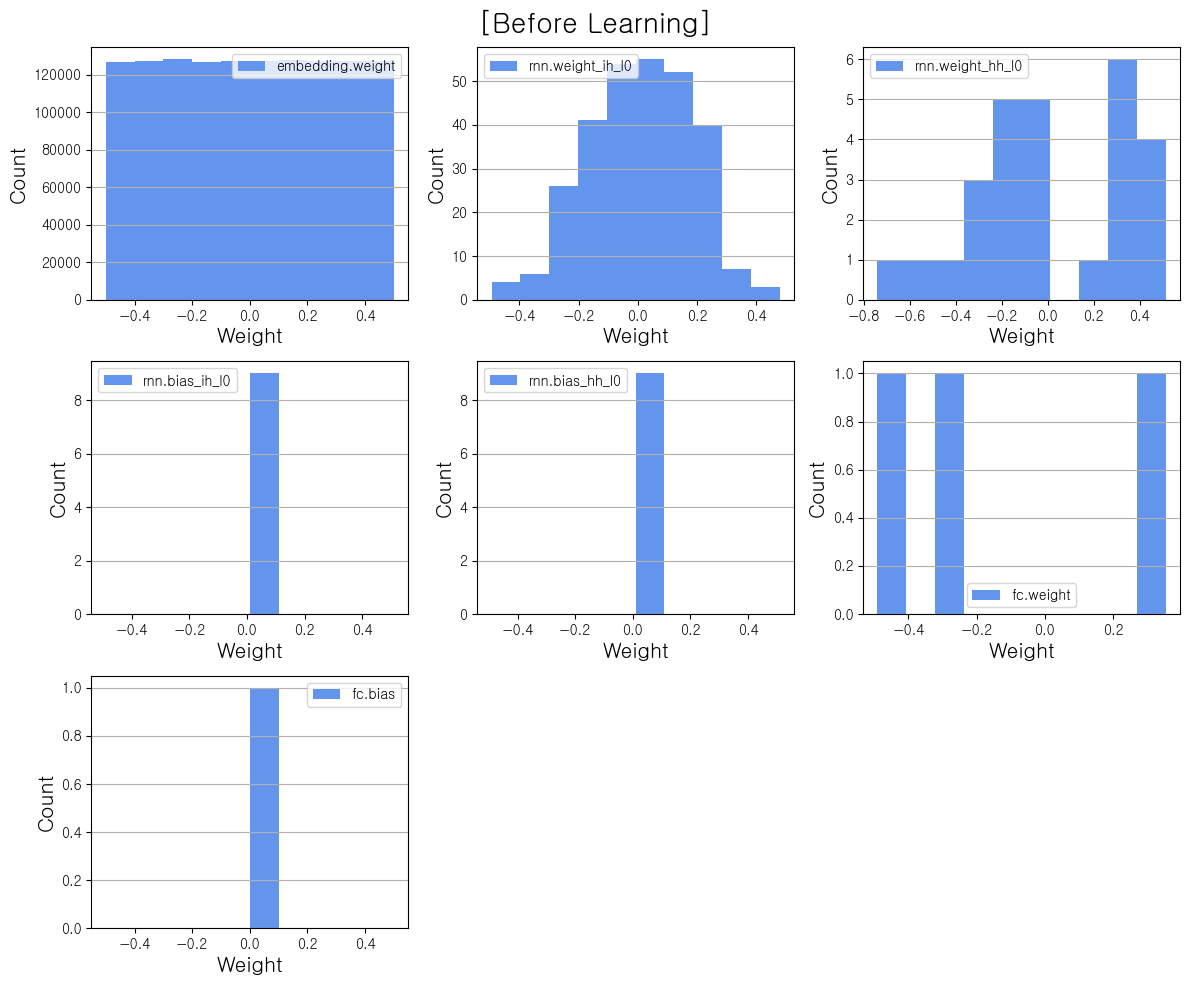

In [51]:
plt.figure(figsize = (12, 10))
plt.suptitle('[Before Learning]', size = 20)
i = 1
for name, params in MY_MODEL.named_parameters():
    plt.subplot(3, 3, i)
    plt.hist(params.detach().numpy().flatten(), label = name, color = 'cornflowerblue')
    plt.xlabel('Weight', size = 15)
    plt.ylabel('Count', size = 15)
    plt.grid(axis = 'y')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

In [52]:
for name, child in MY_MODEL.named_children():
    print(name, type(name), child)

embedding <class 'str'> EmbeddingBag(39789, 32, mode='mean')
rnn <class 'str'> GRU(32, 3, batch_first=True)
fc <class 'str'> Linear(in_features=3, out_features=1, bias=True)
dropout <class 'str'> Dropout(p=0.5, inplace=False)


In [53]:
for idx, (label, text, offsets) in enumerate(trainDL):
    print(label, text, offsets)
    break

tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1]) tensor([  613,   762,   677,  ...,   100,     5, 11694]) tensor([   0,   22,  340,  450,  466,  483,  507,  565,  883,  906, 1089, 1111,
        1140, 1171, 1313, 1336, 1516, 1532, 1621, 1798, 1809, 1989, 2006, 2055,
        2071, 2343, 2430, 2452, 2477, 2495, 2689, 2710, 2790, 2812, 2825, 2851,
        2869, 2886, 3002, 3023, 3174, 3197, 3219, 3237, 3265, 3293, 3473, 3707,
        3746, 3779, 3808, 3852, 3959, 3975, 4286, 4398, 4410, 4433, 4450, 4464,
        4487, 4513, 4546, 4571, 4595, 4631, 4654, 4819, 4835, 4927, 5041, 5058,
        5110, 5413, 5440, 5539

In [54]:
a = torch.Tensor([1, 2, 3, 4])
b = torch.Tensor([1.0, 3.0, 3.0, 2.0])
metrics.accuracy(a, b, task = 'multiclass', num_classes = 4)
c = torch.Tensor([[1] ,[2], [3], [4]])
c.argmax(0)
c.shape

torch.Size([4, 1])

In [55]:
### ===> 학습 진행 함수
def train(model, dataloader, optimizer, criterion):
    # 학습 모드
    model.train()
    
    # 학습 평가 관련 변수들
    train_acc_list = []
    train_loss_list = []
    train_f1score_list = []
    # 배치 학습 진행
    for idx, (label, text, offsets) in enumerate(dataloader):
        
        label, text, offsets = label.to(device), text.to(device), offsets.to(device), 
        
        label = label.unsqueeze(1).float()

        # 학습진행
        predicted_label = model(text, offsets)
        # print(f'predicted_label : {predicted_label.shape}   label : {label.shape} ')
        
        # 손실 계산 및 W,b 업데이트
        optimizer.zero_grad()
        train_loss = criterion(predicted_label, label)
        train_loss_list.append(train_loss.item())
        train_loss.backward()
        # 기울기 소실 및 폭주 예방을 위한 양극단 값 자르기 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
       
        train_accuracy = metrics.accuracy(predicted_label, label, task = 'binary').item()
        train_acc_list.append(train_accuracy)
        train_f1score = metrics.f1_score(predicted_label, label, task = 'binary').item()
        train_f1score_list.append(train_f1score)
    
    train_accuracy = sum(train_acc_list) / len(dataloader)
    train_loss = sum(train_loss_list) / len(dataloader)
    train_f1score = sum(train_f1score_list) / len(dataloader)

    return train_accuracy, train_loss, train_f1score

In [56]:
### ===> 검증 및 테스트 함수
def evaluate(model, dataloader, criterion):
    # 검증 모드 
    model.eval()
    
    # 검증 평가 관련 변수
    val_acc_list = []
    val_loss_list = []
    val_f1score_list = []
    # 검증 진행
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            label = label.unsqueeze(1).float()
            predicted_label = model(text, offsets) 
            val_loss = criterion(predicted_label, label).item()
            val_loss_list.append(val_loss)
           
            val_accuracy = metrics.accuracy(predicted_label, label, task = 'binary').item()
            val_acc_list.append(val_accuracy)
            val_f1score = metrics.f1_score(predicted_label, label, task = 'binary').item()
            val_f1score_list.append(val_f1score)

    val_accuracy = sum(val_acc_list) / len(dataloader)
    val_loss = sum(val_loss_list) / len(dataloader)
    val_f1score = sum(val_f1score_list) / len(dataloader) 
    
    return val_accuracy, val_loss, val_f1score

In [57]:
### ====> 예측 함수
def predict(model, text, text_pipeline):
    with torch.no_grad():
        # 토큰화 > 정수 변환 > 텐서
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

In [58]:
loss_list = [[], []]
acc_list = [[], []]
f1_list = [[], []]

for epoch in range(1, EPOCHS + 1):
    
    train_accuracy, train_loss, train_f1score = train(MY_MODEL, trainDL, OPTIMIZER, CRITERION, epoch)
    val_accuracy, val_loss, val_f1score = evaluate(MY_MODEL, testDL, CRITERION)
    
    print(f"\n[EPOCH: {epoch}] \tTrain Loss: {train_loss:.4f} \tTrain Accuracy: {train_accuracy:.2f} % \tTrain F1 score : {train_f1score}\n")
    print(f"\n[EPOCH: {epoch}] \tTest Loss: {val_loss:.4f} \tTest Accuracy: {val_accuracy:.2f} % \tTest F1 score : {val_f1score}\n")

    loss_list[0].append(train_loss)
    loss_list[1].append(val_loss)
    acc_list[0].append(train_accuracy)
    acc_list[1].append(val_accuracy)
    f1_list[0].append(train_f1score)
    f1_list[1].append(val_f1score)

    SCHEDULER.step(val_loss)
    # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'Early stopping at epoch {epoch}')
        break



[EPOCH: 1], 	Train Loss: 0.6935, 	Train Accuracy: 0.49 % 	Train F1 score : 0.4306707170203565


[EPOCH: 1], 	Test Loss: 0.6935, 	Test Accuracy: 0.49 % 	Test F1 score : 0.5199417297470054


[EPOCH: 2], 	Train Loss: 0.6933, 	Train Accuracy: 0.50 % 	Train F1 score : 0.5007584034072028


[EPOCH: 2], 	Test Loss: 0.6933, 	Test Accuracy: 0.50 % 	Test F1 score : 0.48782008272090943


[EPOCH: 3], 	Train Loss: 0.6931, 	Train Accuracy: 0.50 % 	Train F1 score : 0.5099803256704694


[EPOCH: 3], 	Test Loss: 0.6931, 	Test Accuracy: 0.50 % 	Test F1 score : 0.4923782884771284


[EPOCH: 4], 	Train Loss: 0.6929, 	Train Accuracy: 0.51 % 	Train F1 score : 0.519359316523113


[EPOCH: 4], 	Test Loss: 0.6929, 	Test Accuracy: 0.51 % 	Test F1 score : 0.48947552483500417


[EPOCH: 5], 	Train Loss: 0.6927, 	Train Accuracy: 0.52 % 	Train F1 score : 0.5079368749402818


[EPOCH: 5], 	Test Loss: 0.6927, 	Test Accuracy: 0.52 % 	Test F1 score : 0.5088285348039243


[EPOCH: 6], 	Train Loss: 0.6925, 	Train Accuracy: 0.5

In [64]:
torch.save(MY_MODEL, './Models/GRU_model2_Jeolla.pt')

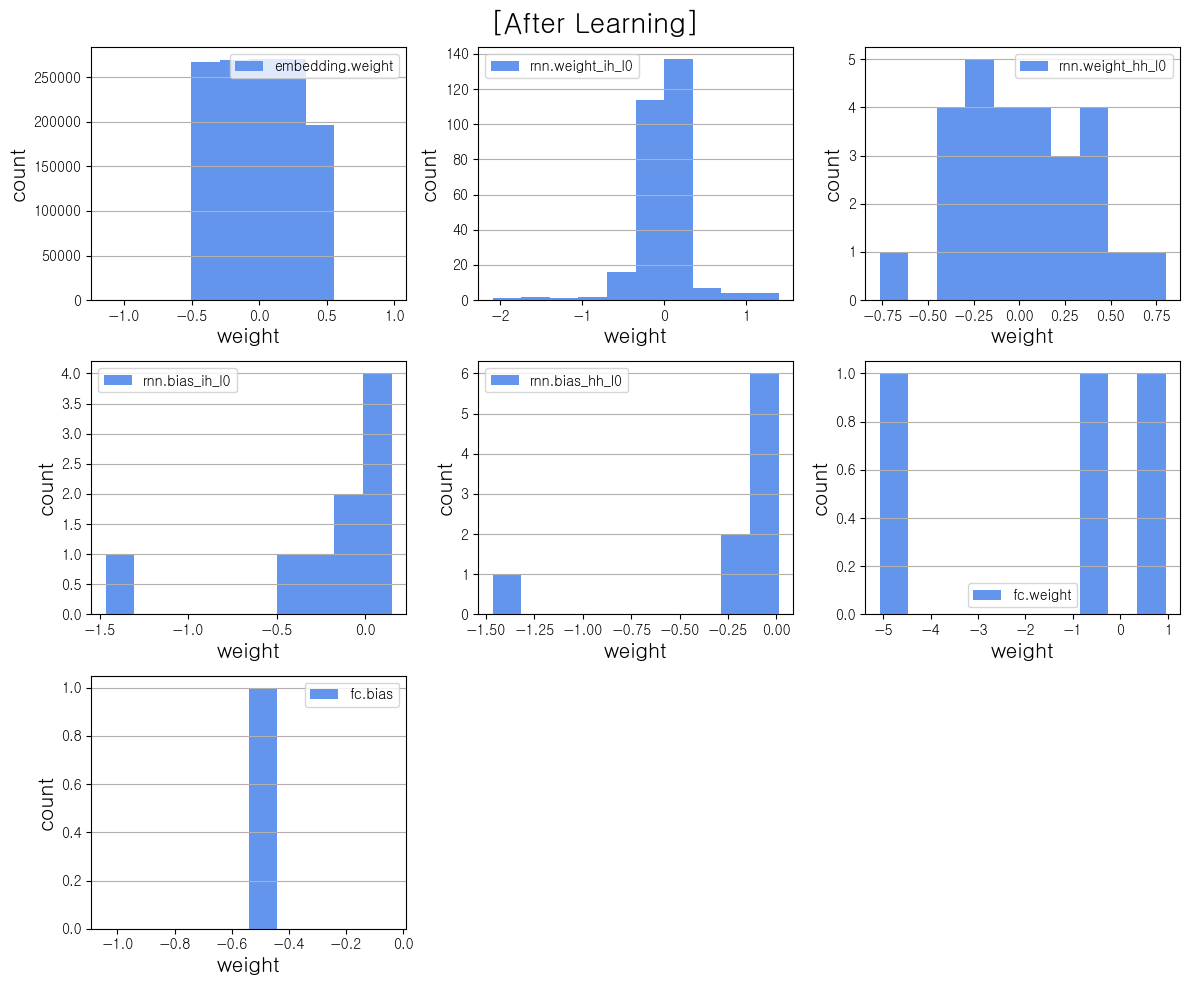

In [63]:
plt.figure(figsize = (12, 10))
plt.suptitle('[After Learning]', size = 20)
i = 1
for name, params in MY_MODEL.named_parameters():
    plt.subplot(3, 3, i)
    plt.hist(params.detach().numpy().flatten(), label = name, color = 'cornflowerblue')
    plt.xlabel('weight', size = 15)
    plt.ylabel('count', size = 15)
    plt.grid(axis = 'y')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()